In [49]:
import sys
import numpy as np
import tqdm
from astropy.constants import m_p, M_sun, k_B, G
import astropy.units as u
from plotting_setup import *

sys.path.append('../pipeline_scripts/')
from pipeline_2D import to_osyris_ivs
from pipeline_main import sink_positions, serialize_directory, sinks, true_sinks, pipeline
from pipeline_1D import to_1D

core_data = {}
initial_sn = [158, 222, 176, 212, 235, 341, 401, 403, 445]



In [103]:
data = pipeline(snap = 534, run = 'sink180fmr05', sink_id=178)
data.recalc_L()
data.calc_trans_xyz()

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4855/4855 [00:30<00:00, 159.12it/s]


Converged mean angular momentum vector after 0 iteration(s)
Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4855/4855 [00:01<00:00, 3699.12it/s]


In [104]:
for p in tqdm.tqdm(data.sn.patches):
    p.c_s = np.sqrt(p.γ * p.P / p.var('d'))
    p.Ω = p.vφ / p.cyl_R

100%|██████████| 4855/4855 [00:00<00:00, 7215.85it/s]


In [105]:
res = 1000; width = 200 
X, Y = np.linspace(-width //2 ,width //2,res), np.linspace(-width //2, width //2,res)
variable = ['c_s', 'Ω', 'γ']

In [106]:
data.to_osyris_ivs(variables=variable, data_name = 'mass_weighted', view = width, resolution=res, weights='mass')

Looping over DISPATCH data to extract data at highest level


  0%|          | 0/2497 [00:00<?, ?it/s]

100%|██████████| 2497/2497 [00:11<00:00, 218.04it/s]


Setting up Osyris data structure


In [107]:
data.to_osyris_ivs(variables=['d'], data_name = 'density', view = width, resolution=res, weights=None)

Looping over DISPATCH data to extract data at highest level


  0%|          | 0/2497 [00:00<?, ?it/s]

100%|██████████| 2497/2497 [00:08<00:00, 281.31it/s]


Setting up Osyris data structure


In [108]:
Σ = data.osyris_ivs['density']['d'] * data.cgs_density
c_s = data.osyris_ivs['mass_weighted']['c_s'] * data.cms_velocity
T = c_s**2 * data.μ * m_p.to('g').value / ( (data.osyris_ivs['mass_weighted']['γ'] * k_B.to('erg/K').value))
Ω = data.osyris_ivs['mass_weighted']['Ω'] / data.sn.scaling.t

X, Y = [np.linspace(-width //2, width // 2, res) for _ in range(2)]
xx, yy = np.meshgrid(X, Y)


G_cgs = G.to('cm**3 / (g *s**2)').value; print(G_cgs)
Q = (c_s * Ω) / (np.pi * G_cgs * Σ)

ext = width // 2

6.674299999999998e-08


### $$ Q = \frac{c_s\Omega}{\pi G\Sigma} \geq 1\;\Rightarrow\; Stable$$

In [109]:
np.log10(Q[Q>0].min())

-3.299008813922749

In [125]:
extracted_values = {key: [] for key in range(6) for key in ['vx', 'vy']}


{'vx': [], 'vy': []}

/tmp/ipykernel_1275439/295155862.py:4: RuntimeWarning: invalid value encountered in log10
  cs = axs.imshow(np.log10(Q), extent = (-ext, ext, -ext, ext), origin ='lower', cmap = 'RdYlGn', vmin = -2, vmax = 2)
/tmp/ipykernel_1275439/295155862.py:5: RuntimeWarning: invalid value encountered in log10
  ct = axs.contour(xx, yy, np.log10(Q), [np.log10(1), np.log10(2)], colors = ['black','red'])


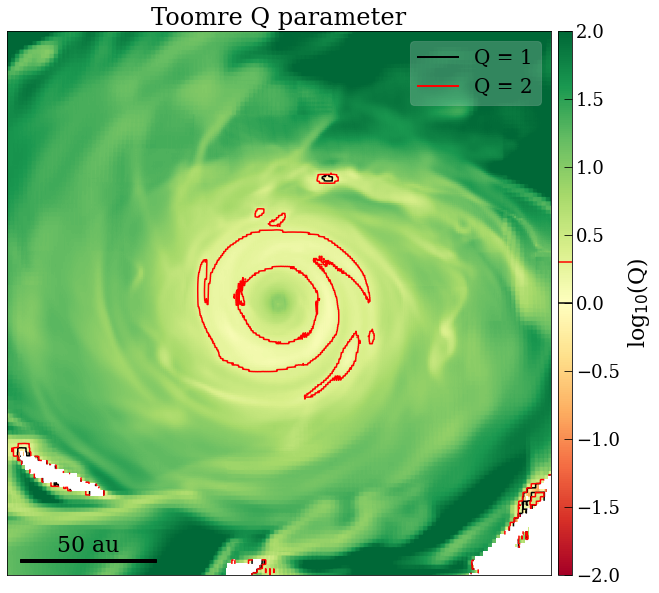

In [115]:
fig, axs = plt.subplots(figsize = (10,10))
axs.set_xticks([]); axs.set_yticks([])

cs = axs.imshow(np.log10(Q), extent = (-ext, ext, -ext, ext), origin ='lower', cmap = 'RdYlGn', vmin = -2, vmax = 2)
ct = axs.contour(xx, yy, np.log10(Q), [np.log10(1), np.log10(2)], colors = ['black','red'])

legend_elements = [ Line2D([0], [0], color='black', lw=2, ls= '-', label='Q = 1'),
                   Line2D([0], [0], color='red', lw=2, ls= '-', label='Q = 2')]

plt.legend(handles = legend_elements, framealpha = 0.2, loc = 'upper right')

contour_labels = []
for i in range(len(contour_labels)):
    ct.collections[i].set_label(contour_labels[i])

cbaxes = fig.add_axes([0.9, 0.125, 0.02, 0.755])
cbar = fig.colorbar(cs, cax = cbaxes)
cbar.set_label('log$_{10}$(Q)', labelpad = 5, fontsize = 22)# y = 1.11, rotation = 0, fontsize = 20)

axs.set(title = 'Toomre Q parameter')
cbar.ax.tick_params(labelsize=18)
cbar.add_lines(ct)
scalebar = AnchoredSizeBar(axs.transData, 50  , '50 au', 'lower left', 
                    pad=0.5,
                    color='black',
                    frameon=False,
                    fontproperties = fm.FontProperties(size=22),
                    size_vertical=1,
                    label_top=True)

axs.add_artist(scalebar)
plt.savefig(save_folder + 'disk_toomreq_180_26kyr', facecolor = 'w', bbox_inches='tight', dpi = 500)